# Durante a etapa de análise dos dados, iremos dividí-la em duas partes:


1.   Primeiramente, analisaremos o conjunto com o intuito de retirarmos análises separadas para cada ano.
2.   Posteriormente, relaizaremos uma análise capaz de abranger todo o conjunto, de Jan de 2014 até Fev de 2024.


*Por favor, observe que existirão diferenças substanciais consideráveis entre as análise extraídas da parte 1 e as análises extraídas da parte 2!*



In [ ]:
# Importando pacotes utilizados nessa parte do projeto:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import Blues

from google.colab import drive
drive.mount('/content/drive')

!pip install plottable

from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image

!pip install plotly
import plotly.graph_objects as go
import plotly.express as px

In [14]:
# Configurações gerais das tabelas que serão utilizadas em todo o projeto:
bg_color = "#F5F5F5"
txt_color = "#141414"

row_colors = {
    "publico":"#B3B0B0"
}

plt.rcParams["text.color"] = txt_color
plt.rcParams["font.family"] = "sans-serif"

In [15]:
# Criando as listas que receberão o resultado da iteração:
Total_Publico_Ano = []
Top_12_Dias_Com_Maiores_Publicos_Por_Ano = []
Top_5_Titulos_Mais_Assistidos_Por_Ano = []
Total_Publico_Estado = []


# Carregando os dados para a análise 2:
Tabela_Geral = pd.read_parquet("/content/drive/MyDrive/br_ancine_diarias_de_cinema/output/bilheteria_geral")
Tabela_Geral['publico'] = Tabela_Geral['publico'].astype(float)
Tabela_Geral = Tabela_Geral.rename(columns={"publico": "Público", "titulo_original" : "Título Original"})

# Criando lista de anos:
lista_de_anos = Tabela_Geral['ano_exibicao'].unique()

# Criando iteração para ter o top 5 para cada ano:
for i  in lista_de_anos:
  condict = Tabela_Geral['ano_exibicao'] == i
  df = Tabela_Geral[condict]


  df_top_5_titulos = df.groupby("Título Original")["Público"].sum().reset_index()
  df_publico_dia = df.groupby("data_exibicao")["Público"].sum().reset_index()
  df_publico_por_estado = df.groupby("uf_sala_complexo")["Público"].sum().reset_index()
  df_total_publico_ano = df.groupby("ano_exibicao")["Público"].sum().reset_index()

  df_dias_preferidos = df_publico_dia.nlargest(12, 'Público')
  df_dias_preferidos["Classificação"] = [*range(1,13)]

  df_titulos_preferidos = df_top_5_titulos.nlargest(5, 'Público')
  df_titulos_preferidos["Classificação"] =  [*range(1,6)]

  Total_Publico_Ano.append(df_total_publico_ano)
  Top_12_Dias_Com_Maiores_Publicos_Por_Ano.append(df_dias_preferidos)
  Top_5_Titulos_Mais_Assistidos_Por_Ano.append(df_titulos_preferidos)
  Total_Publico_Estado.append(df_publico_por_estado)

In [17]:
# Concatenando tabelas presentes em Total_Publico_Ano e organizando dados para uma melhor montagem de tabela:
Df_Rank_Publico_Ano = pd.concat(Total_Publico_Ano, axis = 0).reset_index().drop(columns="index")
Df_Rank_Publico_Ano.set_index("ano_exibicao")

,Público
ano_exibicao,
2014,157163675.0
2015,169331690.0
2016,184881836.0
2017,181832842.0
2018,163307212.0
2019,179281405.0
2020,39354439.0
2021,53024144.0
2022,97410058.0


In [18]:
# Configurações específicas das colunas da tabela Df_Rank_Publico_Ano:
col_defs_1 = [
    ColumnDefinition(
        name="ano_exibicao",
        title = "Ano",
        textprops={"ha": "left", "weight":"bold"},
        width=0.75
    ),
    ColumnDefinition(
        name="Público",
        formatter="{:,.0f}",
        textprops={"ha": "left", "weight":"bold"},
        cmap=normed_cmap(Df_Rank_Publico_Ano['Público'],
                         cmap=matplotlib.cm.viridis, num_stds=0.5),
        width=1
    ),
    ColumnDefinition(
        name = "index",
        textprops={"ha": "center", "va":"center", "color":bg_color},
        width=0.01
    )
]

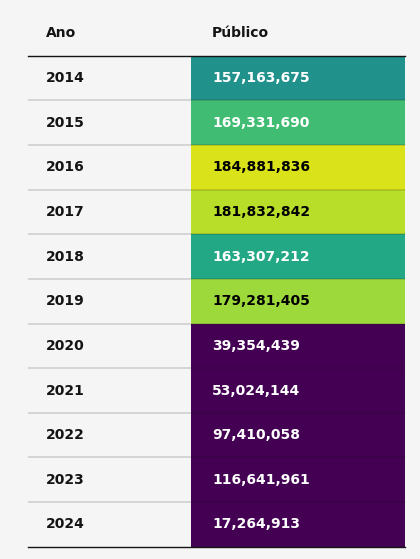

In [20]:
# Criando uma figura que represente a nossa tabela e exportando a imagem:

fig, ax = plt.subplots(figsize=(5,7))
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

Tab_Rank_Publico_Ano = Table(
    Df_Rank_Publico_Ano,
    column_definitions=col_defs_1,
    columns=["ano_exibicao","Público"],
    row_dividers=True,
    #row_divider_kw={"linewidth":1, "linestyle":(0,(1,5))},
    footer_divider=True,
    textprops={"fontsize":10},
    ax=ax,
).autoset_fontcolors(colnames=["Público"])
fig.savefig('/content/drive/MyDrive/analise_exploratoria_br_ancine_diarias_de_cinema/figuras/evolucao_anual_de_expectadores.png', facecolor=ax.get_facecolor(), dpi =200, bbox_inches='tight')

In [21]:
# Descobrindo o dia de maior público dos últimos 10 anos:

Df_Dias_Mais_Povoados = pd.concat(Top_12_Dias_Com_Maiores_Publicos_Por_Ano)
Df_Dias_Mais_Povoados = Df_Dias_Mais_Povoados.sort_values('Público', ascending = False)
Df_Dias_Mais_Povoados['data_exibicao'] = Df_Dias_Mais_Povoados['data_exibicao'].str[-5:] #Tomar cuidado com esta flag


# Verificando primeiro a frequência de repetição das datas dentro da seleção das 12 datas de maior público para cada ano nos últimos 10 anos:

Contagem_Dias_Mais_Povoados = Df_Dias_Mais_Povoados['data_exibicao'].value_counts().reset_index()
Contagem_Dias_Mais_Povoados = Contagem_Dias_Mais_Povoados.rename(columns={"data_exibicao":"Data de Exibição", "count": "Contagem"})
Contagem_Dias_Mais_Povoados = Contagem_Dias_Mais_Povoados[Contagem_Dias_Mais_Povoados['Contagem'].ne(1)]


# Verificando o valor do total de público dentro da seleção das 12 datas de maior público:
Df_Dias_Mais_Povoados_sum_publico = Df_Dias_Mais_Povoados.groupby("data_exibicao")["Público"].sum().reset_index()
Df_Dias_Mais_Povoados_sum_publico = Df_Dias_Mais_Povoados_sum_publico.sort_values("Público", ascending=False)



# Unificando as duas análises:
Df_Dias_Preferidos_dos_Brs = pd.merge(Contagem_Dias_Mais_Povoados, Df_Dias_Mais_Povoados_sum_publico, how = "left", left_on="Data de Exibição", right_on = "data_exibicao", indicator = True)
Df_Dias_Preferidos_dos_Brs = Df_Dias_Preferidos_dos_Brs.drop(columns=["_merge", "data_exibicao"]).rename(columns={"publico":"Público"})
Df_Dias_Preferidos_dos_Brs = Df_Dias_Preferidos_dos_Brs.sort_values("Público", ascending = False)

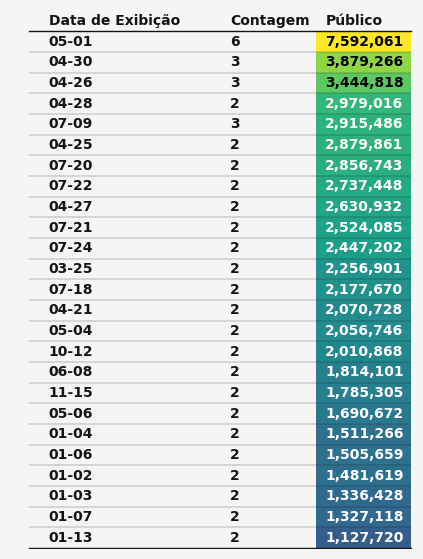

In [22]:
# Plotando e salvando tabela da análise anterior:

fig, ax = plt.subplots(figsize=(5,7))
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

Tablado = Table(
      Df_Dias_Preferidos_dos_Brs,
      column_definitions=[
      ColumnDefinition(
          name="Data de Exibição",
          #title="Data de Exibição",
          textprops={"ha": "left", "weight":"bold"},
          width=2
      ),
      ColumnDefinition(
          name="Contagem",
          #title="Público",
          formatter="{:,.0f}",
          textprops={"ha": "left", "weight":"bold"},
          #cmap=normed_cmap(Top_12_Dias_Com_Maiores_Publicos_Por_Ano[i]['publico'],
                          #cmap=matplotlib.cm.viridis, num_stds=2),
          width=1
      ),
      ColumnDefinition(
          name="Público",
          #title="Público",
          formatter="{:,.0f}",
          textprops={"ha": "left", "weight":"bold"},
          cmap=normed_cmap(Df_Dias_Preferidos_dos_Brs["Público"],
                          cmap=matplotlib.cm.viridis, num_stds=2),
          width=1
      ),
      ColumnDefinition(
          name = "index",
          textprops={"ha": "center", "va":"center", "color":bg_color},
          width=0.01
      )
  ],
      columns=["Data de Exibição","Contagem", "Público"],
      row_dividers=True,
      #row_divider_kw={"linewidth":1, "linestyle":(0,(1,5))},
      footer_divider=True,
      textprops={"fontsize":10},
      ax=ax,
  ).autoset_fontcolors(colnames=["Público"])

fig.savefig('/content/drive/MyDrive/analise_exploratoria_br_ancine_diarias_de_cinema/figuras/datas_preferidas(contagem_e_somatorio).png', facecolor=ax.get_facecolor(), dpi =200, bbox_inches='tight')

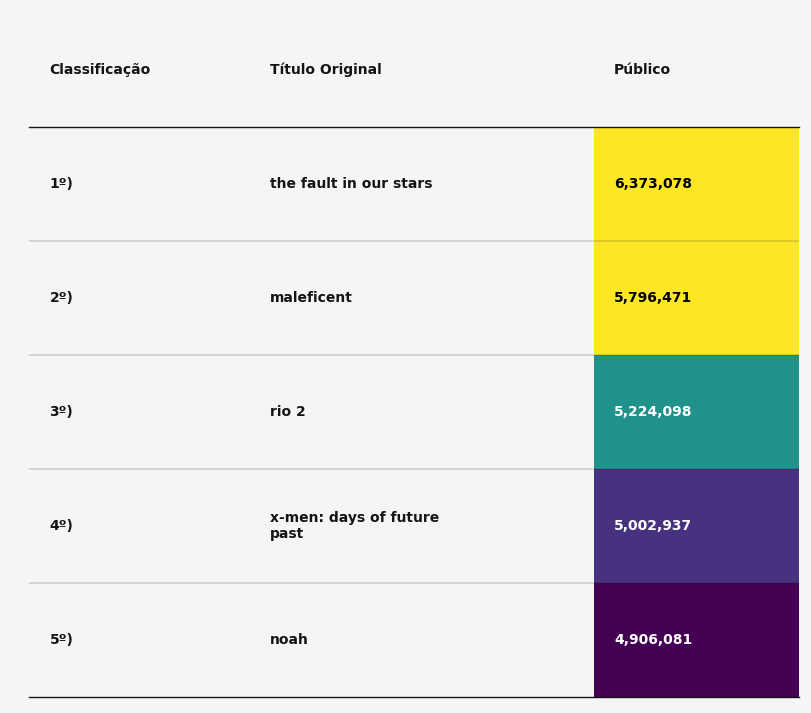

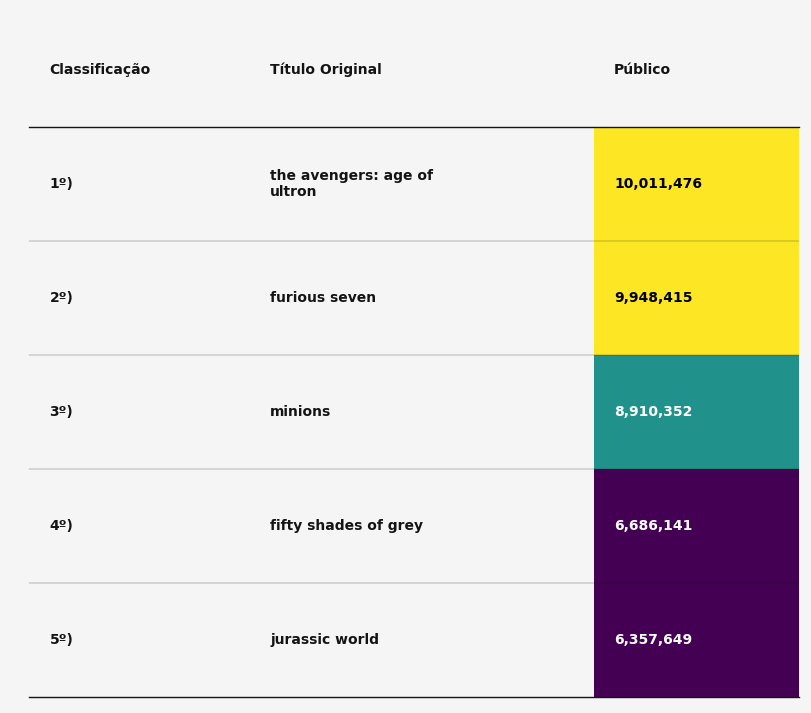

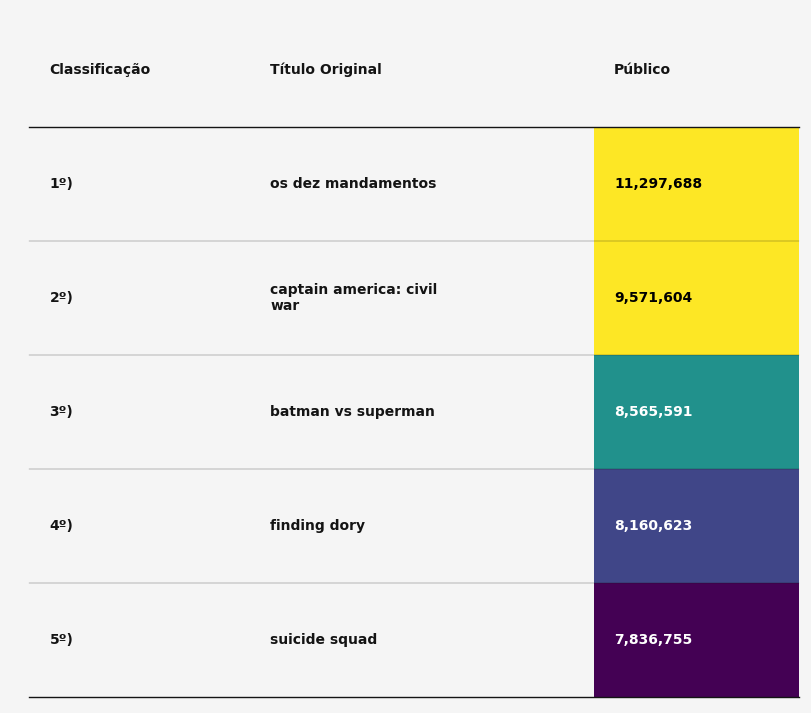

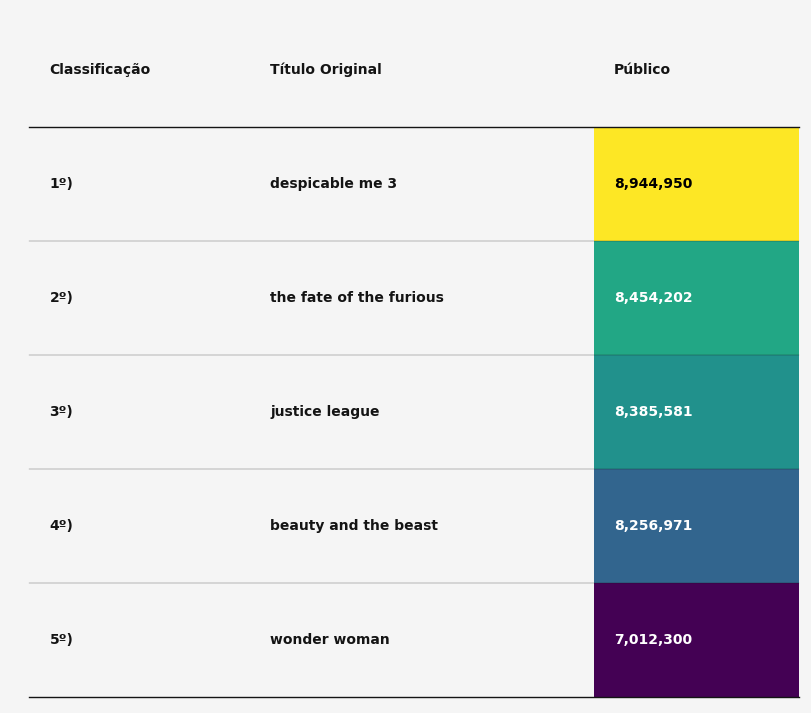

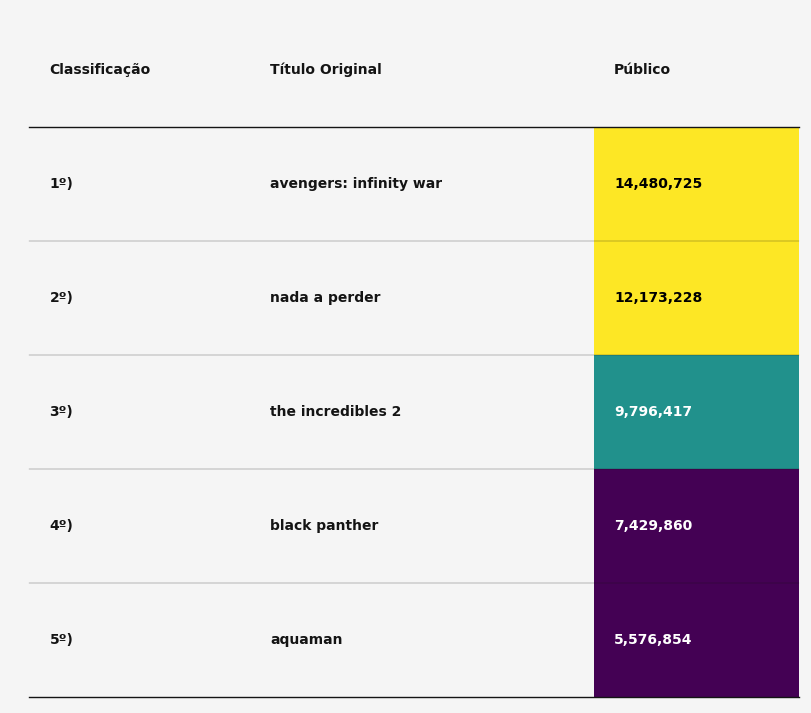

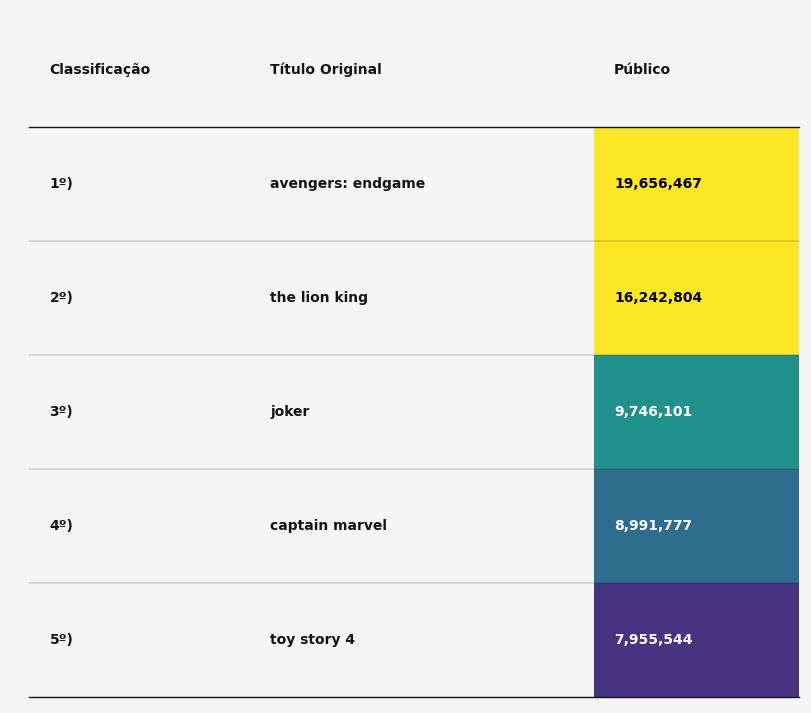

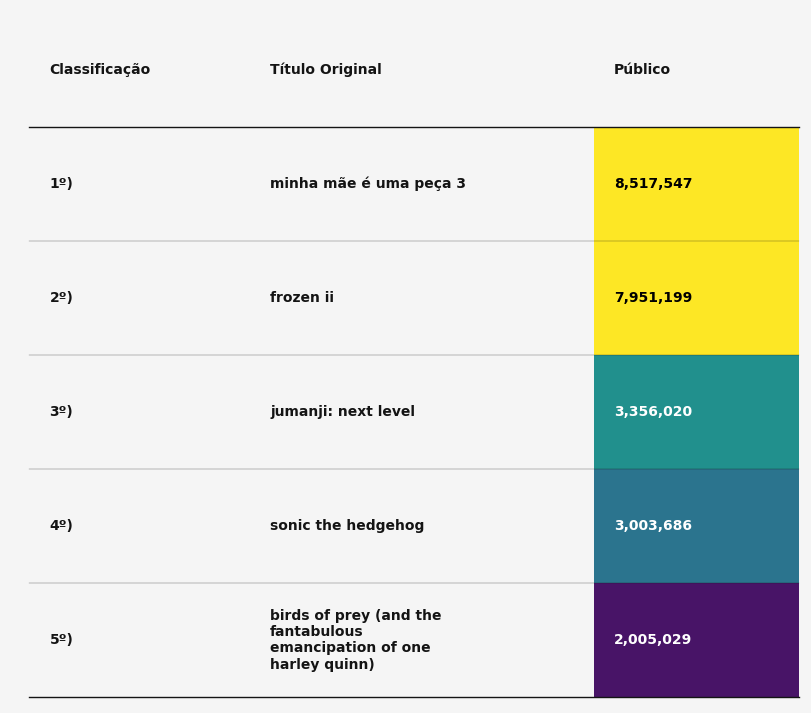

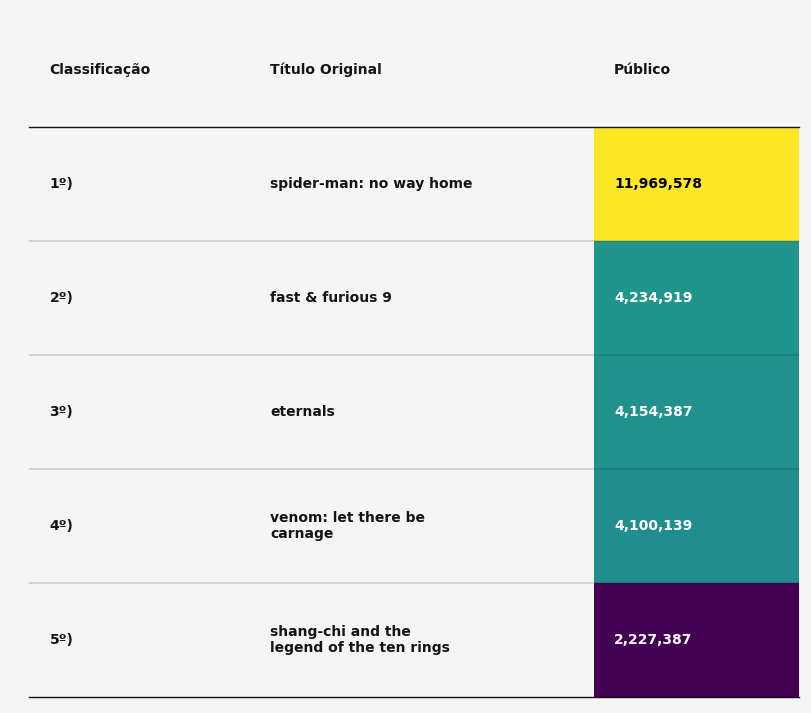

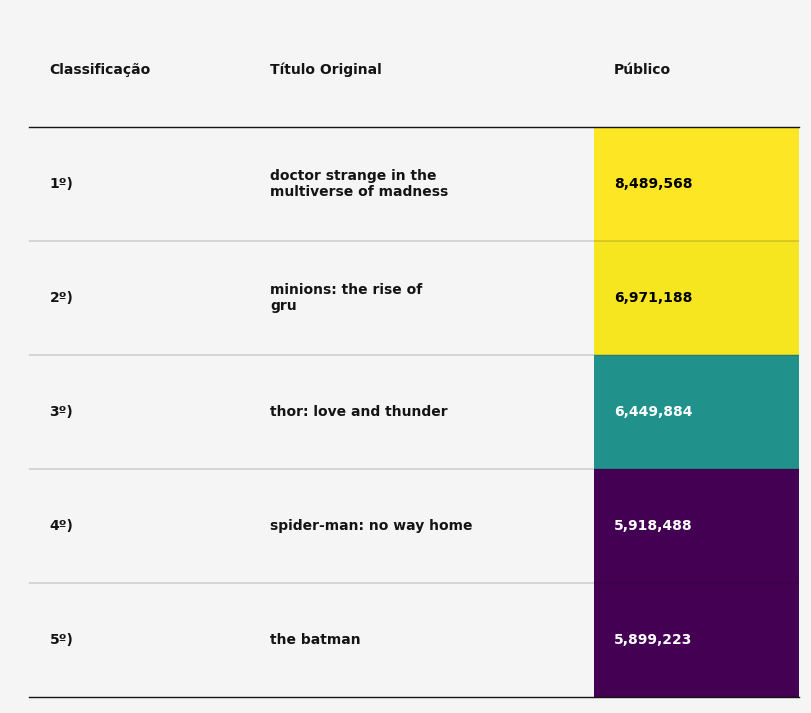

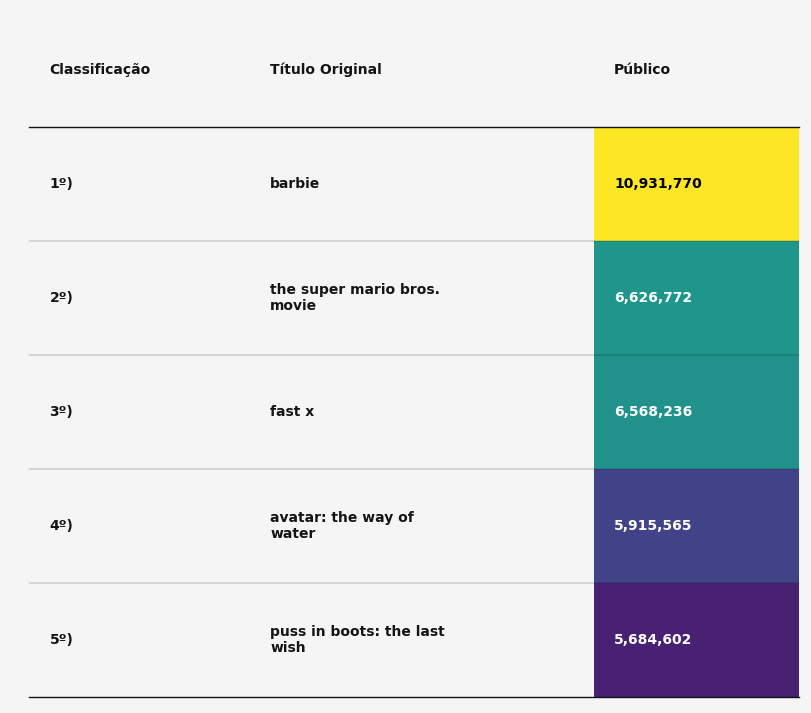

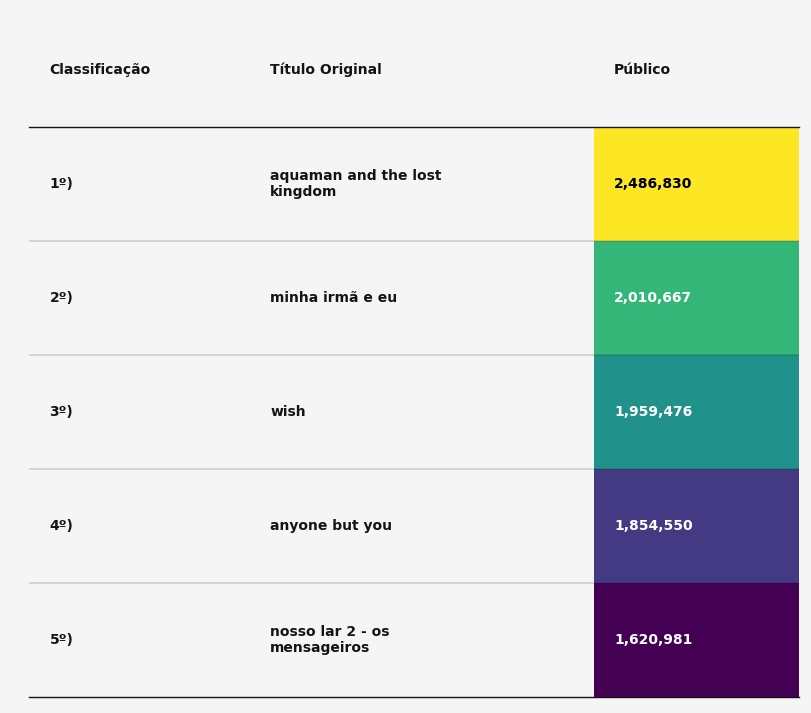

In [23]:
# Plotando e salvando tabelas da análise que nos indicará os 5 títulos mais assistidos em cada ano:
for i in [*range(0,11)]:

  Top_5_Titulos_Mais_Assistidos_Por_Ano[i]["Título Original"] = Top_5_Titulos_Mais_Assistidos_Por_Ano[i]["Título Original"].str.wrap(23)

  fig, ax = plt.subplots(figsize=(10,9))
  fig.set_facecolor(bg_color)
  ax.set_facecolor(bg_color)

  Tabelinda_Moovies = Table(
      Top_5_Titulos_Mais_Assistidos_Por_Ano[i],
      column_definitions=[
      ColumnDefinition(
          name="Título Original",
          #title="Data de Exibição",
          textprops={"ha": "left", "weight":"bold"},
          width=3.5
      ),
      ColumnDefinition(
          name="Público",
          #title="Público",
          formatter="{:,.0f}",
          textprops={"ha": "left", "weight":"bold"},
          cmap=normed_cmap(Top_5_Titulos_Mais_Assistidos_Por_Ano[i]['Público'],
                          cmap=matplotlib.cm.viridis, num_stds=0.5),
          width=2
      ),
      ColumnDefinition(
          name="Classificação",
          #title="Público",
          formatter="{:,.0f}º)",
          textprops={"ha": "left", "weight":"bold"},
          width=2
      ),
      ColumnDefinition(
          name = "index",
          textprops={"ha": "center", "va":"center", "color":bg_color},
          width=0.001
      )
  ],
      columns=["Classificação", "Título Original","Público"],
      row_dividers=True,
      #row_divider_kw={"linewidth":1, "linestyle":(0,(1,5))},
      footer_divider=True,
      textprops={"fontsize":10},
      ax=ax,
  ).autoset_fontcolors(colnames=["Público"])

  exec("fig.savefig('/content/drive/MyDrive/analise_exploratoria_br_ancine_diarias_de_cinema/figuras/filmes_mais_assistidos_ano_{}.png', facecolor=ax.get_facecolor(), dpi =200, bbox_inches='tight')".format(i))

# Início da parte 2:

In [ ]:
# Carregando a tabela geral e refinando detalhes para análise:
Tabelona = pd.read_parquet("/content/drive/MyDrive/br_ancine_diarias_de_cinema/output/bilheteria_geral")
Tabelona = Tabelona.rename(columns={"publico": "Público", "titulo_original" : "Título Original"})
Tabelona['Público'] = Tabelona['Público'].astype(float)

# Agrupando e rankeando os valores para a análise:
Tabelona_groupby_moovie = Tabelona.groupby("Título Original")["Público"].sum().reset_index()
Tabelona_groupby_moovie_50 = Tabelona_groupby_moovie.nlargest(50, "Público")
Tabelona_groupby_moovie_50["Classificação"] = [*range(1,51)]

# Plotando e salvando tabela da análise 0:
fig, ax = plt.subplots(figsize=(10,20))
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

Tabelona_groupby_moovie_50 = Table(
      Tabelona_groupby_moovie_50,
      column_definitions=[
      ColumnDefinition(
          name="Título Original",
          #title="Data de Exibição",
          textprops={"ha": "left", "weight":"bold"},
          width=3
      ),
      ColumnDefinition(
          name="Público",
          #title="Público",
          formatter="{:,.0f}",
          textprops={"ha": "left", "weight":"bold"},
          cmap=normed_cmap(Tabelona_groupby_moovie_50['Público'],
                          cmap=matplotlib.cm.viridis, num_stds=1),
          width=1
      ),
      ColumnDefinition(
          name = "Classificação",
          formatter="{:,.0f}º)",
          textprops={"ha": "left", "weight":"bold"},
          width=0.8
      ),
      ColumnDefinition(
          name = "index",
          textprops={"ha": "center", "va":"center", "color":bg_color},
          width=0.01
      )
  ],
      columns=["Classificação", "Título Original","Público"],
      row_dividers=True,
      #row_divider_kw={"linewidth":1, "linestyle":(0,(1,5))},
      footer_divider=True,
      textprops={"fontsize":10},
      ax=ax,
  ).autoset_fontcolors(colnames=["Público"])

fig.savefig('/content/drive/MyDrive/analise_exploratoria_br_ancine_diarias_de_cinema/figuras/filmes_mais_assistidos_ano_Rank_Tabela_Geral.png', facecolor=ax.get_facecolor(), dpi =200, bbox_inches='tight')

In [ ]:
# Carregando os dados para a análise 1:
Tabela_Geral = pd.read_parquet("/content/drive/MyDrive/br_ancine_diarias_de_cinema/output/bilheteria_geral")
Tabela_Geral['publico'] = Tabela_Geral['publico'].astype(float)


# Cortando a coluna 'data_exibicao' para ter apenas dd-mm:
Tabela_Geral["data_exibicao"] = Tabela_Geral["data_exibicao"].str[-5:]

# Agrupando valores de 'publico' a partir de 'data_exibicao':
Tabela_groupby_date = Tabela_Geral.groupby("data_exibicao")['publico'].sum().reset_index()

# Selecionando os 12 maiores valores
Tabela_groupby_date_12 = Tabela_groupby_date.nlargest(12, "publico").sort_values(by="publico", ascending = False)
Tabela_groupby_date_12["Classificação"] = [*range(1,13)]

# Plotando e salvando tabela da análise 1:
fig, ax = plt.subplots(figsize=(5,7))
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

Tablado = Table(
      Tabela_groupby_date_12,
      column_definitions=[
      ColumnDefinition(
          name="data_exibicao",
          title="Data de Exibição",
          textprops={"ha": "left", "weight":"bold"},
          width=2.5
      ),
      ColumnDefinition(
          name="Classificação",
          #title="Público",
          formatter="{:,.0f}º)",
          textprops={"ha": "left", "weight":"bold"},
          width=1.5
      ),
      ColumnDefinition(
          name="publico",
          title="Público",
          formatter="{:,.0f}",
          textprops={"ha": "left", "weight":"bold"},
          cmap=normed_cmap(Tabela_groupby_date_12["publico"],
                          cmap=matplotlib.cm.viridis, num_stds=0.5),
          width=1.25
      ),
      ColumnDefinition(
          name = "index",
          textprops={"ha": "center", "va":"center", "color":bg_color},
          width=0.01
      )
  ],
      columns=['Classificação', "data_exibicao","publico"],
      row_dividers=True,
      #row_divider_kw={"linewidth":1, "linestyle":(0,(1,5))},
      footer_divider=True,
      textprops={"fontsize":10},
      ax=ax,
  ).autoset_fontcolors(colnames=["publico"])

fig.savefig('/content/drive/MyDrive/analise_exploratoria_br_ancine_diarias_de_cinema/figuras/datas_preferidas(somatorio).png', facecolor=ax.get_facecolor(), dpi =200, bbox_inches='tight')


In [ ]:
# Carregando os dados para a análise 2:
Tabela_Geral = pd.read_parquet("/content/drive/MyDrive/br_ancine_diarias_de_cinema/output/bilheteria_geral")
Tabela_Geral['publico'] = Tabela_Geral['publico'].astype(float)
Tabela_Geral = Tabela_Geral.rename(columns={"publico": "Público", "titulo_original" : "Título Original"})

# Gerando os filtros para partir Tabela_Geral em filmes nacionais e filmes internacionais:
condict1 = Tabela_Geral['pais_obra'] != "brasil"
condict2 = Tabela_Geral['pais_obra'] == "brasil"
condict3 = Tabela_Geral['pais_obra'] == "estados unidos"
nacionais = Tabela_Geral[condict2]
internacionais = Tabela_Geral[condict1]
norte_americanos = Tabela_Geral[condict3]

# Obtendo o samotário de público para as duas tabelas:
total_publico_nacionais = nacionais["Público"].sum().astype(int)
total_publico_internacionais = internacionais["Público"].sum().astype(int)
total_publico_norte_americanos = norte_americanos['Público'].sum().astype(int)
publico_total = Tabela_Geral["Público"].sum().astype(int)

# Organizando uma única tabela com esses valores:
molde = [("Filmes Nacionais", total_publico_nacionais, "Público Total", total_publico_nacionais / publico_total, ".", '#6C7C32'), ("Filmes Internacionais", total_publico_internacionais, "Público Total", total_publico_internacionais / publico_total, "/", "B2828D"), ("Filmes Norte Americanos", total_publico_norte_americanos, "Filmes Internacionais", total_publico_norte_americanos / total_publico_internacionais, "", "#0D2A63"), ("Público Total", publico_total, "", publico_total / publico_total, "", "#E15F99")]
df_medidas_publico = pd.DataFrame(molde, columns = ["Labels", "Valor Absoluto", "Parents", "Valor Relativo", "Shape", "Colors"])
df_medidas_publico.head(5)

In [ ]:
# Criando um Sunburst chart para df_medidas_publico:
fig = go.Figure(go.Sunburst(
        labels=df_medidas_publico["Labels"],
        parents=df_medidas_publico["Parents"],
        values=df_medidas_publico["Valor Absoluto"],
        branchvalues="total",
        outsidetextfont={"size": 20, "color": "#000000", },#377eb8"},
        leaf={"opacity": 0.9},
        textfont_size=16,
        insidetextorientation="horizontal",
        #textfont="Arial",
        marker=dict(
            pattern=dict(
                #shape=df_medidas_publico["Shape"], solidity=0.9
            ),
            #colors=df_medidas_publico["Colors"],
            colorscale = "viridis"
        )
    )
)

fig.update_layout(margin=dict(t=0, l=0, r=0, b=0),
                  plot_bgcolor='#F5F5F5',
                  paper_bgcolor="#F5F5F5")

fig.show()

In [ ]:
# Observando a evolução da proporção de "Qtde de Filmes Nacionais / Qtde de Filmes Internacionais" por ano:

# Carregando os dados para a análise 3:
Tabela_Geral = pd.read_parquet("/content/drive/MyDrive/br_ancine_diarias_de_cinema/output/bilheteria_geral")
Tabela_Geral['publico'] = Tabela_Geral['publico'].astype(float)
Tabela_Geral = Tabela_Geral.rename(columns={"publico": "Público", "titulo_original" : "Título Original"})

# Criando as listas que irão receber provisioriamente os valores de nossa análise:
lista_total_nacionais = []
lista_total_geral = []
lista_total_internacionais = []

# Lista de anos:
lista_de_anos = Tabela_Geral["ano_exibicao"].unique()

# Desenvolvendo iteração para capturar esses valores:
for i in lista_de_anos:
  condict0 = Tabela_Geral["ano_exibicao"] == i
  df = Tabela_Geral[condict0]
  condict1 = df["pais_obra"] == "brasil"
  condict2 = df["pais_obra"] != "brasil"
  nacionais = df[condict1]
  internacionais = df[condict2]
  total_nacionais = nacionais["Título Original"].nunique()
  total_internacionais = internacionais["Título Original"].nunique()
  total_geral = df["Título Original"].nunique()
  lista_total_nacionais.append(total_nacionais)
  lista_total_internacionais.append(total_internacionais)
  lista_total_geral.append(total_geral)

In [ ]:
# Desenvolvendo um DataFrame para organizar os dados da análise 3:
df_ratios = pd.DataFrame({'Ano': lista_de_anos, 'Ratio Nacionais': [a / b for a, b in zip(lista_total_nacionais, lista_total_geral)], 'Ratio Internacionais':[a / b for a, b in zip(lista_total_internacionais, lista_total_geral)]})
df_ratios = df_ratios.drop([10, 7, 6], axis=0).reset_index().drop(columns=["index"])

In [ ]:
fig, ax = plt.subplots(figsize=(4,3.25))
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# Define os ticks do eixo y para todos os anos:
plt.yticks(range(len(df_ratios['Ano'])), df_ratios['Ano'])

# Plotando as barras para os ratios 1 e 2:
plt.barh(range(len(df_ratios['Ano'])), df_ratios['Ratio Nacionais'], color='#6a0dad', label='Nacionais/Total')
plt.barh(range(len(df_ratios['Ano'])), df_ratios['Ratio Internacionais'], color='#ffdd1f', label='Internacionais/Total', left=df_ratios['Ratio Nacionais'])

# Adicionando rótulos nas barras:
for i in range(len(df_ratios['Ano'])):
    plt.text(df_ratios['Ratio Nacionais'][i] / 2, i, str(round(df_ratios['Ratio Nacionais'][i]*100, 2)) + '%', ha='center', va='center', color='white')
    plt.text(df_ratios['Ratio Nacionais'][i] + df_ratios['Ratio Internacionais'][i] / 2, i, str(round(df_ratios['Ratio Internacionais'][i]*100, 2)) + '%', ha='center', va='center', color='black')

plt.xlabel('Taxa %')
plt.ylabel('Ano')
plt.title('Mix: Filmes Nacionais e Internacionais')
#plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
plt.xlim(0, 1)  # Limitando o eixo x entre 0 e 1
plt.gca().spines['top'].set_visible(False)  # Removendo as bordas superior e direita
plt.gca().spines['right'].set_visible(False)
plt.grid(False)  # Removendo a grade

# Exibindo o gráfico
plt.show()


fig.savefig('/content/drive/MyDrive/analise_exploratoria_br_ancine_diarias_de_cinema/figuras/evolucao_cine_nacional.png', facecolor=ax.get_facecolor(), dpi =200, bbox_inches='tight')

In [ ]:
# Criando as listas que receberão o resultado da iteração:
Total_Publico_Estado = []

# Carregando os dados para a análise 4:
Tabela_Geral = pd.read_parquet("/content/drive/MyDrive/br_ancine_diarias_de_cinema/output/bilheteria_geral")
Tabela_Geral['publico'] = Tabela_Geral['publico'].astype(float)
Tabela_Geral = Tabela_Geral.rename(columns={"publico": "Público", "titulo_original" : "Título Original"})

# Criando uma lista de anos:
lista_de_anos = Tabela_Geral['ano_exibicao'].unique()

# Agrupando valores por UF:
for i in lista_de_anos:
  condict = Tabela_Geral["ano_exibicao"] == i
  df = Tabela_Geral[condict]
  df = df.groupby("uf_sala_complexo")['Público'].sum().reset_index().sort_values("uf_sala_complexo")
  df["ano"] = i
  Total_Publico_Estado.append(df)

# Concatenando os dados armazenados na lista e reorganizando a tabela para uma melhor visualização:
evolucao_publico_estado = pd.concat(Total_Publico_Estado, axis = 0)
evolucao_publico_estado = evolucao_publico_estado.pivot(index="uf_sala_complexo", columns="ano", values="Público").reset_index()

# Desvendando curiosidades:
publico_rj_sp = evolucao_publico_estado.query("uf_sala_complexo == 'rj' | uf_sala_complexo == 'sp'")["2023"].sum()
publico_outras_ufs = evolucao_publico_estado.query("uf_sala_complexo not in 'rj' & uf_sala_complexo not in 'sp'")["2023"].sum()
proporcao_centros_outras_ufs = publico_rj_sp / publico_outras_ufs

# Resultados:
proporcao_centros_outras_ufs